In [1]:
import os
import glob
import random
import re
import copy
import json
from collections import defaultdict

import tqdm
import pydicom
import matplotlib as mpl
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from skimage import exposure
import cv2

## Setup

Place kaggle dataset directory in `.`, renamed to `kaggle` such that `./kaggle/test/` exists.

In [19]:
test = glob.glob("kaggle/test/test/**/*.dcm", recursive=True)

In [20]:
test_sax = sorted(filter(lambda path: 'sax' in path, test))
test_sax

['kaggle/test/test/1000/study/sax_48/IM-6372-0001.dcm',
 'kaggle/test/test/1000/study/sax_48/IM-6372-0002.dcm',
 'kaggle/test/test/1000/study/sax_48/IM-6372-0003.dcm',
 'kaggle/test/test/1000/study/sax_48/IM-6372-0004.dcm',
 'kaggle/test/test/1000/study/sax_48/IM-6372-0005.dcm',
 'kaggle/test/test/1000/study/sax_48/IM-6372-0006.dcm',
 'kaggle/test/test/1000/study/sax_48/IM-6372-0007.dcm',
 'kaggle/test/test/1000/study/sax_48/IM-6372-0008.dcm',
 'kaggle/test/test/1000/study/sax_48/IM-6372-0009.dcm',
 'kaggle/test/test/1000/study/sax_48/IM-6372-0010.dcm',
 'kaggle/test/test/1000/study/sax_48/IM-6372-0011.dcm',
 'kaggle/test/test/1000/study/sax_48/IM-6372-0012.dcm',
 'kaggle/test/test/1000/study/sax_48/IM-6372-0013.dcm',
 'kaggle/test/test/1000/study/sax_48/IM-6372-0014.dcm',
 'kaggle/test/test/1000/study/sax_48/IM-6372-0015.dcm',
 'kaggle/test/test/1000/study/sax_48/IM-6372-0016.dcm',
 'kaggle/test/test/1000/study/sax_48/IM-6372-0017.dcm',
 'kaggle/test/test/1000/study/sax_48/IM-6372-001

## Examine DCM File

In [10]:
dcm = pydicom.dcmread(test_sax[0])

In [11]:
dcm

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 216
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.379199097710849655204362771730755711434
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
(0002, 0016) Source Application Entity Title     AE: ''
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'RETRO', 'NORM', 'DIS2D']
(0008, 0013) Instance Creation Time              TM: '090654.574000'
(0008, 0016) SOP Class UID                       UI: MR Imag

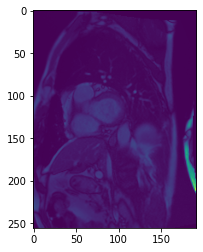

In [12]:
plt.imshow(dcm.pixel_array)

In [13]:
def scale_pixel_array(pixel_array):
    start, end = np.percentile(pixel_array, (2, 98))
    return exposure.rescale_intensity(pixel_array, in_range=(start, end))

kaggle/test/test/1062/study/sax_6/IM-5559-0004.dcm
[0.4242769058677, 0.8049514380546, -0.4147798084781, -0.6990586985496, 2.89721532E-07, -0.7150642880063]


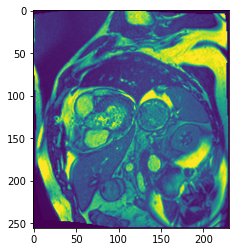

In [21]:
path = random.sample(test_sax, 1)[0]
dcm = pydicom.dcmread(path)
image = scale_pixel_array(dcm.pixel_array)
plt.imshow(image)
print(path)
print(dcm.ImageOrientationPatient)

## Extract Identifiers (Regex)

In [57]:
all_paths = {}
for t in ["train", "validate", "test"]:
    paths = glob.glob("kaggle/{t}/{t}/**/*.dcm".format(t=t), recursive=True)
    paths = list(sorted(filter(lambda p: 'sax' in p, paths)))
    print(paths[:5])
    all_paths[t] = paths

['kaggle/train/train/1/study/sax_10/IM-4562-0001.dcm', 'kaggle/train/train/1/study/sax_10/IM-4562-0002.dcm', 'kaggle/train/train/1/study/sax_10/IM-4562-0003.dcm', 'kaggle/train/train/1/study/sax_10/IM-4562-0004.dcm', 'kaggle/train/train/1/study/sax_10/IM-4562-0005.dcm']
['kaggle/validate/validate/501/study/sax_26/IM-11494-0001.dcm', 'kaggle/validate/validate/501/study/sax_26/IM-11494-0002.dcm', 'kaggle/validate/validate/501/study/sax_26/IM-11494-0003.dcm', 'kaggle/validate/validate/501/study/sax_26/IM-11494-0004.dcm', 'kaggle/validate/validate/501/study/sax_26/IM-11494-0005.dcm']
['kaggle/test/test/1000/study/sax_48/IM-6372-0001.dcm', 'kaggle/test/test/1000/study/sax_48/IM-6372-0002.dcm', 'kaggle/test/test/1000/study/sax_48/IM-6372-0003.dcm', 'kaggle/test/test/1000/study/sax_48/IM-6372-0004.dcm', 'kaggle/test/test/1000/study/sax_48/IM-6372-0005.dcm']


In [90]:
re_path = re.compile('kaggle/\w*/\w*/(?P<patient>\d*)/study/sax_(?P<slice>\d*)/.*?-(?P<phase>\d*).dcm')
path = all_paths["train"][0]
match = re_path.match(path)
print(path)
print(match.groups())

kaggle/train/train/1/study/sax_10/IM-4562-0001.dcm
('1', '10', '0001')


In [91]:
for t, paths in all_paths.items():
    for path in paths:
        if not re_path.match(path):
            raise AssertionError("Invalid path: {}".format(path))
print("All valid")

All valid


## Slice Distribution

In [306]:
_slices = lambda: defaultdict(list)
_phases = lambda: defaultdict(_slices)
patients = defaultdict(_phases)
outliers = defaultdict(list)

duplicates = []
for t, paths in all_paths.items():
    for path in tqdm.tqdm(paths):
        match = re_path.match(path)
        assert(match)
        patient, sid, phase = match.groups()
        if int(sid) in patients[int(patient)][int(phase)]:
            duplicates.append(int(patient))
        patients[int(patient)][int(phase)][int(sid)] = path
outliers["duplicate"] = list(sorted(set(duplicates)))

100%|██████████| 145350/145350 [00:00<00:00, 280884.75it/s]


### Slice Distribution Per Phase

In [307]:
for patient, phases in patients.items():
    for phase, slices in phases.items():
        print(patient, phase, sorted(slices.keys()))

1 1 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 38, 57]
1 2 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 38, 57]
1 3 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 38, 57]
1 4 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 38, 57]
1 5 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 38, 57]
1 6 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 38, 57]
1 7 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 38, 57]
1 8 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 38, 57]
1 9 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 38, 57]
1 10 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 38, 57]
1 11 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 38, 57]
1 12 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 38, 57]
1 13 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 38, 57]
1 14 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 38, 57]
1 15 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 38, 57]
1 16 [5, 6, 7, 8, 9, 10, 11, 12, 1

116 28 [42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]
116 29 [42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]
116 30 [42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]
117 1 [71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]
117 2 [71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]
117 3 [71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]
117 4 [71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]
117 5 [71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]
117 6 [71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]
117 7 [71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]
117 8 [71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]
117 9 [71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]
117 10 [71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]
117 11 [71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]
117 12 [71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]
117 13 [71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]
117 14 [71, 72, 73, 7

131 18 [9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20]
131 19 [9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20]
131 20 [9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20]
131 21 [9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20]
131 22 [9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20]
131 23 [9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20]
131 24 [9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20]
131 25 [9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20]
131 26 [9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20]
131 27 [9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20]
131 28 [9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20]
131 29 [9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20]
131 30 [9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20]
132 1 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
132 2 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
132 3 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
132 4 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
132 5 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
132 6 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
132 7 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
132 8 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
1

147 8 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
147 9 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
147 10 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
147 11 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
147 12 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
147 13 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
147 14 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
147 15 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
147 16 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
147 17 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
147 18 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
147 19 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
147 20 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
147 21 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
147 22 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
147 23 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
147 24 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
147 25 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
147 26 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
147 27 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
147 28 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
147 29 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
147 30 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
148 1 [5, 6, 

165 2 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
165 3 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
165 4 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
165 5 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
165 6 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
165 7 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
165 8 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
165 9 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
165 10 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
165 11 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
165 12 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
165 13 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
165 14 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
165 15 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
165 16 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
165 17 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
165 18 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 

182 4 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
182 5 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
182 6 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
182 7 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
182 8 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
182 9 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
182 10 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
182 11 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
182 12 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
182 13 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
182 14 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
182 15 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
182 16 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
182 17 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
182 18 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
182 19 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
182 20 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
182 21 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
182 22 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
182 23 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
182 24 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
182 25 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
182 26 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
182 27 [5, 6, 7, 

197 24 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
197 25 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
197 26 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
197 27 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
197 28 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
197 29 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
197 30 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
198 1 [18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
198 2 [18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
198 3 [18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
198 4 [18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
198 5 [18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
198 6 [18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
198 7 [18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
198 8 [18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
198 9 [18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
198 10 [18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
198 11 [18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
198 12 [18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
198 13 [18, 19, 20, 21, 22, 23, 24, 25, 2

211 14 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
211 15 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
211 16 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
211 17 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
211 18 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
211 19 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
211 20 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
211 21 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
211 22 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
211 23 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
211 24 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
211 25 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
211 26 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
211 27 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
211 28 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
211 29 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
211 30 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
212 1 [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
212 2 [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
212 3 [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
212 4 [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
212 5 [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
212 6 [7, 8,

227 4 [42, 43, 44, 45, 46, 47, 48, 49, 50]
227 5 [42, 43, 44, 45, 46, 47, 48, 49, 50]
227 6 [42, 43, 44, 45, 46, 47, 48, 49, 50]
227 7 [42, 43, 44, 45, 46, 47, 48, 49, 50]
227 8 [42, 43, 44, 45, 46, 47, 48, 49, 50]
227 9 [42, 43, 44, 45, 46, 47, 48, 49, 50]
227 10 [42, 43, 44, 45, 46, 47, 48, 49, 50]
227 11 [42, 43, 44, 45, 46, 47, 48, 49, 50]
227 12 [42, 43, 44, 45, 46, 47, 48, 49, 50]
227 13 [42, 43, 44, 45, 46, 47, 48, 49, 50]
227 14 [42, 43, 44, 45, 46, 47, 48, 49, 50]
227 15 [42, 43, 44, 45, 46, 47, 48, 49, 50]
227 16 [42, 43, 44, 45, 46, 47, 48, 49, 50]
227 17 [42, 43, 44, 45, 46, 47, 48, 49, 50]
227 18 [42, 43, 44, 45, 46, 47, 48, 49, 50]
227 19 [42, 43, 44, 45, 46, 47, 48, 49, 50]
227 20 [42, 43, 44, 45, 46, 47, 48, 49, 50]
227 21 [42, 43, 44, 45, 46, 47, 48, 49, 50]
227 22 [42, 43, 44, 45, 46, 47, 48, 49, 50]
227 23 [42, 43, 44, 45, 46, 47, 48, 49, 50]
227 24 [42, 43, 44, 45, 46, 47, 48, 49, 50]
227 25 [42, 43, 44, 45, 46, 47, 48, 49, 50]
227 26 [42, 43, 44, 45, 46, 47, 48, 49

237 26 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
237 27 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
237 28 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
237 29 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
237 30 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
238 1 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
238 2 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
238 3 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
238 4 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
238 5 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
238 6 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
238 7 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
238 8 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
238 9 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
238 10 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
238 11 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
238 12 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
238 13 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
238 14 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
238 15 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
238 16 [13, 14, 15, 16, 17, 1

252 16 [5, 6, 7, 8, 9, 10, 11, 12, 13]
252 17 [5, 6, 7, 8, 9, 10, 11, 12, 13]
252 18 [5, 6, 7, 8, 9, 10, 11, 12, 13]
252 19 [5, 6, 7, 8, 9, 10, 11, 12, 13]
252 20 [5, 6, 7, 8, 9, 10, 11, 12, 13]
252 21 [5, 6, 7, 8, 9, 10, 11, 12, 13]
252 22 [5, 6, 7, 8, 9, 10, 11, 12, 13]
252 23 [5, 6, 7, 8, 9, 10, 11, 12, 13]
252 24 [5, 6, 7, 8, 9, 10, 11, 12, 13]
252 25 [5, 6, 7, 8, 9, 10, 11, 12, 13]
252 26 [5, 6, 7, 8, 9, 10, 11, 12, 13]
252 27 [5, 6, 7, 8, 9, 10, 11, 12, 13]
252 28 [5, 6, 7, 8, 9, 10, 11, 12, 13]
252 29 [5, 6, 7, 8, 9, 10, 11, 12, 13]
252 30 [5, 6, 7, 8, 9, 10, 11, 12, 13]
253 1 [28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
253 2 [28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
253 3 [28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
253 4 [28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
253 5 [28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
253 6 [28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
253 7 [28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
253 8 [28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
253 9 [28, 29, 30, 31, 32, 33, 34, 35, 

268 6 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
268 7 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
268 8 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
268 9 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
268 10 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
268 11 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
268 12 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
268 13 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
268 14 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
268 15 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
268 16 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
268 17 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
268 18 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
268 19 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
268 20 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
268 21 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
268 22 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
268 23 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
268 24 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
268 25 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
268 26 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
268 27 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
268 28 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
268 29 [5, 6, 7

283 24 [5, 6, 7, 8, 9, 10, 11, 12]
283 25 [5, 6, 7, 8, 9, 10, 11, 12]
283 26 [5, 6, 7, 8, 9, 10, 11, 12]
283 27 [5, 6, 7, 8, 9, 10, 11, 12]
283 28 [5, 6, 7, 8, 9, 10, 11, 12]
283 29 [5, 6, 7, 8, 9, 10, 11, 12]
283 30 [5, 6, 7, 8, 9, 10, 11, 12]
284 1 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
284 2 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
284 3 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
284 4 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
284 5 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
284 6 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
284 7 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
284 8 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
284 9 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
284 10 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
284 11 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
284 12 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
284 13 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
284 14 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
284 15 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
284 16 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 

299 13 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
299 14 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
299 15 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
299 16 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
299 17 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
299 18 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
299 19 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
299 20 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
299 21 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
299 22 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
299 23 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
299 24 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
299 25 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
299 26 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
299 27 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
299 28 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
299 29 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
299 30 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
3 1 [43, 44, 45, 46, 47, 48, 49, 50]
3 2 [43, 44, 45, 46, 47, 48, 49, 50]
3 3 [43,

313 3 [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
313 4 [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
313 5 [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
313 6 [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
313 7 [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
313 8 [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
313 9 [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
313 10 [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
313 11 [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
313 12 [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
313 13 [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
313 14 [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
313 15 [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
313 16 [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
313 17 [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
313 18 [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
313 19 [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
313 20 [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
313 21 [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
313 22 [22, 23, 24,

333 10 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
333 11 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
333 12 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
333 13 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
333 14 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
333 15 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
333 16 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
333 17 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
333 18 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
333 19 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
333 20 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
333 21 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
333 22 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
333 23 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
333 24 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
333 25 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
333 26 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
333 27 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 

352 29 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
352 30 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
353 1 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
353 2 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
353 3 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
353 4 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
353 5 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
353 6 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
353 7 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
353 8 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
353 9 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
353 10 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
353 11 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
353 12 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
353 13 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
353 14 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
353 15 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
353 16 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
353 17 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
353 18 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
353 19 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
353

369 6 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 33]
369 7 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 33]
369 8 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 33]
369 9 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 33]
369 10 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 33]
369 11 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 33]
369 12 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 33]
369 13 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 33]
369 14 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 33]
369 15 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 33]
369 16 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 33]
369 17 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 33]
369 18 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 33]
369 19 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 33]
369 20 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 33]
369 21 [11, 12, 13, 14, 15, 16, 17, 18, 19, 

389 13 [5, 6, 7, 8, 9, 10, 11, 12, 13]
389 14 [5, 6, 7, 8, 9, 10, 11, 12, 13]
389 15 [5, 6, 7, 8, 9, 10, 11, 12, 13]
389 16 [5, 6, 7, 8, 9, 10, 11, 12, 13]
389 17 [5, 6, 7, 8, 9, 10, 11, 12, 13]
389 18 [5, 6, 7, 8, 9, 10, 11, 12, 13]
389 19 [5, 6, 7, 8, 9, 10, 11, 12, 13]
389 20 [5, 6, 7, 8, 9, 10, 11, 12, 13]
389 21 [5, 6, 7, 8, 9, 10, 11, 12, 13]
389 22 [5, 6, 7, 8, 9, 10, 11, 12, 13]
389 23 [5, 6, 7, 8, 9, 10, 11, 12, 13]
389 24 [5, 6, 7, 8, 9, 10, 11, 12, 13]
389 25 [5, 6, 7, 8, 9, 10, 11, 12, 13]
389 26 [5, 6, 7, 8, 9, 10, 11, 12, 13]
389 27 [5, 6, 7, 8, 9, 10, 11, 12, 13]
389 28 [5, 6, 7, 8, 9, 10, 11, 12, 13]
389 29 [5, 6, 7, 8, 9, 10, 11, 12, 13]
389 30 [5, 6, 7, 8, 9, 10, 11, 12, 13]
39 1 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
39 2 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
39 3 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
39 4 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
39 5 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
39 6 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21

403 2 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
403 3 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
403 4 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
403 5 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
403 6 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
403 7 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
403 8 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
403 9 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
403 10 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
403 11 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
403 12 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
403 13 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
403 14 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
403 15 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
403 16 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
403 17 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
403 18 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
403 19 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
403 20 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
403 21 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
403 22 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
403 23 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
403 24 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
403 25 [5, 6, 7, 8,

42 23 [7, 8, 9, 10, 11, 12, 13, 14]
42 24 [7, 8, 9, 10, 11, 12, 13, 14]
42 25 [7, 8, 9, 10, 11, 12, 13, 14]
42 26 [7, 8, 9, 10, 11, 12, 13, 14]
42 27 [7, 8, 9, 10, 11, 12, 13, 14]
42 28 [7, 8, 9, 10, 11, 12, 13, 14]
42 29 [7, 8, 9, 10, 11, 12, 13, 14]
42 30 [7, 8, 9, 10, 11, 12, 13, 14]
420 1 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
420 2 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
420 3 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
420 4 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
420 5 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
420 6 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
420 7 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
420 8 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
420 9 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
420 10 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
420 11 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
420 12 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
420 13 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
420 14 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
420 15 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
420 16 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
420 17 [5, 6, 7, 8, 9, 10, 11, 12

438 29 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
438 30 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
439 1 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
439 2 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
439 3 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
439 4 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
439 5 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
439 6 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
439 7 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
439 8 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
439 9 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
439 10 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
439 11 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
439 12 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
439 13 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
439 14 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
439 15 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
439 16 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
439 17 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
439 18 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
439 19 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
439 20 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
439 21 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
439 22 [5, 6, 7, 8, 

454 23 [47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
454 24 [47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
454 25 [47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
454 26 [47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
454 27 [47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
454 28 [47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
454 29 [47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
454 30 [47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
455 1 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
455 2 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
455 3 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
455 4 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
455 5 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
455 6 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
455 7 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
455 8 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
455 9 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
455 10 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
455 11 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
455 12 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
455 13 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
455 14 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
455 15 [6

474 23 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
474 24 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
474 25 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
474 26 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
474 27 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
474 28 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
474 29 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
474 30 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
475 1 [5, 6, 7, 8, 9, 10, 11, 12, 13]
475 2 [5, 6, 7, 8, 9, 10, 11, 12, 13]
475 3 [5, 6, 7, 8, 9, 10, 11, 12, 13]
475 4 [5, 6, 7, 8, 9, 10, 11, 12, 13]
475 5 [5, 6, 7, 8, 9, 10, 11, 12, 13]
475 6 [5, 6, 7, 8, 9, 10, 11, 12, 13]
475 7 [5, 6, 7, 8, 9, 10, 11, 12, 13]
475 8 [5, 6, 7, 8, 9, 10, 11, 12, 13]
475 9 [5, 6, 7, 8, 9, 10, 11, 12, 13]
475 10 [5, 6, 7, 8, 9, 10, 11, 12, 13]
475 11 [5, 6, 7, 8, 9, 10, 11, 12, 13]
475 12 [5, 6, 7, 8, 9, 10, 11, 12, 13]
475 13 [5, 6, 7, 8, 9, 10, 11, 12, 13]
475 14 [5, 6, 7, 8, 9, 10, 11, 12, 13]
475 15 [5, 6, 7, 8, 9, 10, 11, 12, 13]
475 16 [5, 6, 7, 8, 9, 10, 11, 12, 13]
475 17 [5

494 30 [7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
495 1 [6, 7, 8, 9, 10, 11, 12, 13, 14]
495 2 [6, 7, 8, 9, 10, 11, 12, 13, 14]
495 3 [6, 7, 8, 9, 10, 11, 12, 13, 14]
495 4 [6, 7, 8, 9, 10, 11, 12, 13, 14]
495 5 [6, 7, 8, 9, 10, 11, 12, 13, 14]
495 6 [6, 7, 8, 9, 10, 11, 12, 13, 14]
495 7 [6, 7, 8, 9, 10, 11, 12, 13, 14]
495 8 [6, 7, 8, 9, 10, 11, 12, 13, 14]
495 9 [6, 7, 8, 9, 10, 11, 12, 13, 14]
495 10 [6, 7, 8, 9, 10, 11, 12, 13, 14]
495 11 [6, 7, 8, 9, 10, 11, 12, 13, 14]
495 12 [6, 7, 8, 9, 10, 11, 12, 13, 14]
495 13 [6, 7, 8, 9, 10, 11, 12, 13, 14]
495 14 [6, 7, 8, 9, 10, 11, 12, 13, 14]
495 15 [6, 7, 8, 9, 10, 11, 12, 13, 14]
495 16 [6, 7, 8, 9, 10, 11, 12, 13, 14]
495 17 [6, 7, 8, 9, 10, 11, 12, 13, 14]
495 18 [6, 7, 8, 9, 10, 11, 12, 13, 14]
495 19 [6, 7, 8, 9, 10, 11, 12, 13, 14]
495 20 [6, 7, 8, 9, 10, 11, 12, 13, 14]
495 21 [6, 7, 8, 9, 10, 11, 12, 13, 14]
495 22 [6, 7, 8, 9, 10, 11, 12, 13, 14]
495 23 [6, 7, 8, 9, 10, 11, 12, 13, 14]
495 24 [6, 7, 8, 9, 10, 11, 12, 13, 14]
495 

61 10 [19, 20, 22, 24, 25, 27, 28, 29, 30, 31, 32]
61 11 [19, 20, 22, 24, 25, 27, 28, 29, 30, 31, 32]
61 12 [19, 20, 22, 24, 25, 27, 28, 29, 30, 31, 32]
61 13 [19, 20, 22, 24, 25, 27, 28, 29, 30, 31, 32]
61 14 [19, 20, 22, 24, 25, 27, 28, 29, 30, 31, 32]
61 15 [19, 20, 22, 24, 25, 27, 28, 29, 30, 31, 32]
61 16 [19, 20, 22, 24, 25, 27, 28, 29, 30, 31, 32]
61 17 [19, 20, 22, 24, 25, 27, 28, 29, 30, 31, 32]
61 18 [19, 20, 22, 24, 25, 27, 28, 29, 30, 31, 32]
61 19 [19, 20, 22, 24, 25, 27, 28, 29, 30, 31, 32]
61 20 [19, 20, 22, 24, 25, 27, 28, 29, 30, 31, 32]
61 21 [19, 20, 22, 24, 25, 27, 28, 29, 30, 31, 32]
61 22 [19, 20, 22, 24, 25, 27, 28, 29, 30, 31, 32]
61 23 [19, 20, 22, 24, 25, 27, 28, 29, 30, 31, 32]
61 24 [19, 20, 22, 24, 25, 27, 28, 29, 30, 31, 32]
61 25 [19, 20, 22, 24, 25, 27, 28, 29, 30, 31, 32]
61 26 [19, 20, 22, 24, 25, 27, 28, 29, 30, 31, 32]
61 27 [19, 20, 22, 24, 25, 27, 28, 29, 30, 31, 32]
61 28 [19, 20, 22, 24, 25, 27, 28, 29, 30, 31, 32]
61 29 [19, 20, 22, 24, 25, 27, 

77 1 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
77 2 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
77 3 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
77 4 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
77 5 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
77 6 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
77 7 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
77 8 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
77 9 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
77 10 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
77 11 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
77 12 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
77 13 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
77 14 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
77 15 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
77 16 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
77 17 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
77 18 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
77 19 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
77 20 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
77 21 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
77 22 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1

95 5 [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
95 6 [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
95 7 [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
95 8 [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
95 9 [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
95 10 [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
95 11 [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
95 12 [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
95 13 [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
95 14 [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
95 15 [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
95 16 [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
95 17 [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
95 18 [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
95 19 [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
95 20 [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
95 21 [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
95 22 [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
95 23 [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
95 24 [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
95 25

518 11 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
518 12 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
518 13 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
518 14 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
518 15 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
518 16 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
518 17 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
518 18 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
518 19 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
518 20 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
518 21 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
518 22 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
518 23 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
518 24 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
518 25 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
518 26 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
518 27 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
518 28 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
518 29 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
518 30 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
519 1 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
519 2 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
519 3 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

540 18 [7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
540 19 [7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
540 20 [7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
540 21 [7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
540 22 [7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
540 23 [7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
540 24 [7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
540 25 [7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
540 26 [7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
540 27 [7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
540 28 [7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
540 29 [7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
540 30 [7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
541 1 [5, 6, 7, 8, 9, 10, 11, 12, 13]
541 2 [5, 6, 7, 8, 9, 10, 11, 12, 13]
541 3 [5, 6, 7, 8, 9, 10, 11, 12, 13]
541 4 [5, 6, 7, 8, 9, 10, 11, 12, 13]
541 5 [5, 6, 7, 8, 9, 10, 11, 12, 13]
541 6 [5, 6, 7, 8, 9, 10, 11, 12, 13]
541 7 [5, 6, 7, 8, 9, 10, 11, 12, 13]
541 8 [5, 6, 7, 8, 9, 10, 11, 12, 13]
541 9 [5, 6, 7, 8, 9, 10, 11, 12, 13]
541 10 [5, 6, 7, 8, 9, 10, 11, 12, 13]
541 11 [5, 6, 7, 8, 9, 10, 11, 12,

558 15 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
558 16 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
558 17 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
558 18 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
558 19 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
558 20 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
558 21 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
558 22 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
558 23 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
558 24 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
558 25 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
558 26 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
558 27 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
558 28 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
558 29 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
558 30 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
559 1 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
559 2 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
559 3 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
559 4 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
559 5 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
559 6 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
559 7 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
55

579 14 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 23]
579 15 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 23]
579 16 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 23]
579 17 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 23]
579 18 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 23]
579 19 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 23]
579 20 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 23]
579 21 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 23]
579 22 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 23]
579 23 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 23]
579 24 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 23]
579 25 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 23]
579 26 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 23]
579 27 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 23]
579 28 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 23]
579 29 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 23]
579 30 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 23]
580 1 [5, 6, 7, 8, 9, 10, 11, 12, 13]
580 2 [5, 6, 7, 8, 9, 10, 1

600 30 [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
601 1 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
601 2 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
601 3 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
601 4 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
601 5 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
601 6 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
601 7 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
601 8 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
601 9 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
601 10 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
601 11 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
601 12 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
601 13 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
601 14 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
601 15 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
601 16 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
601 17 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
601 18 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
601 19 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
601 20 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
601 21 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
601 22 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
601 23 [5, 6

617 11 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
617 12 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
617 13 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
617 14 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
617 15 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
617 16 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
617 17 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
617 18 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
617 19 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
617 20 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
617 21 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
617 22 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
617 23 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
617 24 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
617 25 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
617 26 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
617 27 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
617 28 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
617 29 [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
617 30 [45, 

632 19 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
632 20 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
632 21 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
632 22 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
632 23 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
632 24 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
632 25 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
632 26 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
632 27 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
632 28 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
632 29 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
632 30 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
633 1 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
633 2 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
633 3 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
633 4 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
633 5 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
633 6 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
633 7 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
633 8 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
633 9 [11, 12, 13, 14, 15, 16, 17, 18, 19, 2

647 23 [6, 7, 8, 9, 10, 11, 12, 13, 14]
647 24 [6, 7, 8, 9, 10, 11, 12, 13, 14]
647 25 [6, 7, 8, 9, 10, 11, 12, 13, 14]
647 26 [6, 7, 8, 9, 10, 11, 12, 13, 14]
647 27 [6, 7, 8, 9, 10, 11, 12, 13, 14]
647 28 [6, 7, 8, 9, 10, 11, 12, 13, 14]
647 29 [6, 7, 8, 9, 10, 11, 12, 13, 14]
647 30 [6, 7, 8, 9, 10, 11, 12, 13, 14]
648 1 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
648 2 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
648 3 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
648 4 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
648 5 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
648 6 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
648 7 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
648 8 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
648 9 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
648 10 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
648 11 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
648 12 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
648 13 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
648 14 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
648 15 [5, 6, 7, 8, 9, 10, 11, 

663 29 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
663 30 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
664 1 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
664 2 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
664 3 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
664 4 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
664 5 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
664 6 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
664 7 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
664 8 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
664 9 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
664 10 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
664 11 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
664 12 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
664 13 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
664 14 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
664 15 [1

680 8 [5, 6, 7, 8, 9, 10, 11, 12, 13]
680 9 [5, 6, 7, 8, 9, 10, 11, 12, 13]
680 10 [5, 6, 7, 8, 9, 10, 11, 12, 13]
680 11 [5, 6, 7, 8, 9, 10, 11, 12, 13]
680 12 [5, 6, 7, 8, 9, 10, 11, 12, 13]
680 13 [5, 6, 7, 8, 9, 10, 11, 12, 13]
680 14 [5, 6, 7, 8, 9, 10, 11, 12, 13]
680 15 [5, 6, 7, 8, 9, 10, 11, 12, 13]
680 16 [5, 6, 7, 8, 9, 10, 11, 12, 13]
680 17 [5, 6, 7, 8, 9, 10, 11, 12, 13]
680 18 [5, 6, 7, 8, 9, 10, 11, 12, 13]
680 19 [5, 6, 7, 8, 9, 10, 11, 12, 13]
680 20 [5, 6, 7, 8, 9, 10, 11, 12, 13]
680 21 [5, 6, 7, 8, 9, 10, 11, 12, 13]
680 22 [5, 6, 7, 8, 9, 10, 11, 12, 13]
680 23 [5, 6, 7, 8, 9, 10, 11, 12, 13]
680 24 [5, 6, 7, 8, 9, 10, 11, 12, 13]
680 25 [5, 6, 7, 8, 9, 10, 11, 12, 13]
680 26 [5, 6, 7, 8, 9, 10, 11, 12, 13]
680 27 [5, 6, 7, 8, 9, 10, 11, 12, 13]
680 28 [5, 6, 7, 8, 9, 10, 11, 12, 13]
680 29 [5, 6, 7, 8, 9, 10, 11, 12, 13]
680 30 [5, 6, 7, 8, 9, 10, 11, 12, 13]
681 1 [6, 7, 8, 9, 10, 11, 12, 13, 14]
681 2 [6, 7, 8, 9, 10, 11, 12, 13, 14]
681 3 [6, 7, 8, 9, 10, 11, 

697 22 [5, 6, 7, 8, 9, 10, 11, 12, 13]
697 23 [5, 6, 7, 8, 9, 10, 11, 12, 13]
697 24 [5, 6, 7, 8, 9, 10, 11, 12, 13]
697 25 [5, 6, 7, 8, 9, 10, 11, 12, 13]
697 26 [5, 6, 7, 8, 9, 10, 11, 12, 13]
697 27 [5, 6, 7, 8, 9, 10, 11, 12, 13]
697 28 [5, 6, 7, 8, 9, 10, 11, 12, 13]
697 29 [5, 6, 7, 8, 9, 10, 11, 12, 13]
697 30 [5, 6, 7, 8, 9, 10, 11, 12, 13]
698 1 [12, 13, 14, 15, 16, 17, 18, 19, 33, 34, 35, 36]
698 2 [12, 13, 14, 15, 16, 17, 18, 19, 33, 34, 35, 36]
698 3 [12, 13, 14, 15, 16, 17, 18, 19, 33, 34, 35, 36]
698 4 [12, 13, 14, 15, 16, 17, 18, 19, 33, 34, 35, 36]
698 5 [12, 13, 14, 15, 16, 17, 18, 19, 33, 34, 35, 36]
698 6 [12, 13, 14, 15, 16, 17, 18, 19, 33, 34, 35, 36]
698 7 [12, 13, 14, 15, 16, 17, 18, 19, 33, 34, 35, 36]
698 8 [12, 13, 14, 15, 16, 17, 18, 19, 33, 34, 35, 36]
698 9 [12, 13, 14, 15, 16, 17, 18, 19, 33, 34, 35, 36]
698 10 [12, 13, 14, 15, 16, 17, 18, 19, 33, 34, 35, 36]
698 11 [12, 13, 14, 15, 16, 17, 18, 19, 33, 34, 35, 36]
698 12 [12, 13, 14, 15, 16, 17, 18, 19, 33

1013 12 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
1013 13 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
1013 14 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
1013 15 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
1013 16 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
1013 17 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
1013 18 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
1013 19 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
1013 20 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
1013 21 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
1013 22 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
1013 23 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
1013 24 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
1013 25 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
1013 26 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
1013 27 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
1013 28 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
1013 29 [36, 37, 38, 39, 40, 41

1030 7 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
1030 8 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
1030 9 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
1030 10 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
1030 11 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
1030 12 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
1030 13 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
1030 14 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
1030 15 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
1030 16 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
1030 17 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
1030 18 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
1030 19 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
1030 20 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
1030 21 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
1030 22 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
1030 23 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
1030 24 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
1030 25 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
1030 26 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
1030 27 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14,

1048 20 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
1048 21 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
1048 22 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
1048 23 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
1048 24 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
1048 25 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
1048 26 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
1048 27 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
1048 28 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
1048 29 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
1048 30 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
1049 1 [5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18]
1049 2 [5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18]
1049 3 [5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18]
1049 4 [5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18]
1049 5 [5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18]
1049 6 [5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18]
1049 7 [5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18]
1049 8 [5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18]
1049 9 [5

1067 27 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
1067 28 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
1067 29 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
1067 30 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
1068 1 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
1068 2 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
1068 3 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
1068 4 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
1068 5 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
1068 6 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
1068 7 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
1068 8 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
1068 9 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
1068 10 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
1068 11 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
1068 12 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
1068 13 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
1068 14 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
1068 15 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
1068 16 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
1068 17 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 

1082 10 [11]
1082 11 [11]
1082 12 [11]
1082 13 [11]
1082 14 [11]
1082 15 [11]
1082 16 [11]
1082 17 [11]
1082 18 [11]
1082 19 [11]
1082 20 [11]
1082 21 [11]
1082 22 [11]
1082 23 [11]
1082 24 [11]
1082 25 [11]
1082 26 [11]
1082 27 [11]
1082 28 [11]
1082 29 [11]
1082 30 [11]
1083 1 [49, 50, 51, 52, 53, 55, 56, 57, 58]
1083 2 [49, 50, 51, 52, 53, 55, 56, 57, 58]
1083 3 [49, 50, 51, 52, 53, 55, 56, 57, 58]
1083 4 [49, 50, 51, 52, 53, 55, 56, 57, 58]
1083 5 [49, 50, 51, 52, 53, 55, 56, 57, 58]
1083 6 [49, 50, 51, 52, 53, 55, 56, 57, 58]
1083 7 [49, 50, 51, 52, 53, 55, 56, 57, 58]
1083 8 [49, 50, 51, 52, 53, 55, 56, 57, 58]
1083 9 [49, 50, 51, 52, 53, 55, 56, 57, 58]
1083 10 [49, 50, 51, 52, 53, 55, 56, 57, 58]
1083 11 [49, 50, 51, 52, 53, 55, 56, 57, 58]
1083 12 [49, 50, 51, 52, 53, 55, 56, 57, 58]
1083 13 [49, 50, 51, 52, 53, 55, 56, 57, 58]
1083 14 [49, 50, 51, 52, 53, 55, 56, 57, 58]
1083 15 [49, 50, 51, 52, 53, 55, 56, 57, 58]
1083 16 [49, 50, 51, 52, 53, 55, 56, 57, 58]
1083 17 [49, 50,

1100 26 [47, 48, 49, 50, 51, 52, 53, 54, 55]
1100 27 [47, 48, 49, 50, 51, 52, 53, 54, 55]
1100 28 [47, 48, 49, 50, 51, 52, 53, 54, 55]
1100 29 [47, 48, 49, 50, 51, 52, 53, 54, 55]
1100 30 [47, 48, 49, 50, 51, 52, 53, 54, 55]
1101 1 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
1101 2 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
1101 3 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
1101 4 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
1101 5 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
1101 6 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
1101 7 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
1101 8 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
1101 9 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
1101 10 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
1101 11 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
1101 12 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
1101 13 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
1101 14 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
1101 15 [10, 11, 12, 13, 14, 15, 16, 17, 1

1117 28 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
1117 29 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
1117 30 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
1118 1 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
1118 2 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
1118 3 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
1118 4 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
1118 5 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
1118 6 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
1118 7 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
1118 8 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
1118 9 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
1118 10 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
1118 11 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
1118 12 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
1118 13 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
1118 14 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
1118 15 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
1118 16 [5

1136 15 [9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20]
1136 16 [9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20]
1136 17 [9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20]
1136 18 [9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20]
1136 19 [9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20]
1136 20 [9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20]
1136 21 [9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20]
1136 22 [9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20]
1136 23 [9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20]
1136 24 [9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20]
1136 25 [9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20]
1136 26 [9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20]
1136 27 [9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20]
1136 28 [9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20]
1136 29 [9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20]
1136 30 [9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20]
1137 1 [37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
1137 2 [37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
1137 3 [37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 

716 2 [61, 62, 63, 64, 65, 66, 67, 68, 69]
716 3 [61, 62, 63, 64, 65, 66, 67, 68, 69]
716 4 [61, 62, 63, 64, 65, 66, 67, 68, 69]
716 5 [61, 62, 63, 64, 65, 66, 67, 68, 69]
716 6 [61, 62, 63, 64, 65, 66, 67, 68, 69]
716 7 [61, 62, 63, 64, 65, 66, 67, 68, 69]
716 8 [61, 62, 63, 64, 65, 66, 67, 68, 69]
716 9 [61, 62, 63, 64, 65, 66, 67, 68, 69]
716 10 [61, 62, 63, 64, 65, 66, 67, 68, 69]
716 11 [61, 62, 63, 64, 65, 66, 67, 68, 69]
716 12 [61, 62, 63, 64, 65, 66, 67, 68, 69]
716 13 [61, 62, 63, 64, 65, 66, 67, 68, 69]
716 14 [61, 62, 63, 64, 65, 66, 67, 68, 69]
716 15 [61, 62, 63, 64, 65, 66, 67, 68, 69]
716 16 [61, 62, 63, 64, 65, 66, 67, 68, 69]
716 17 [61, 62, 63, 64, 65, 66, 67, 68, 69]
716 18 [61, 62, 63, 64, 65, 66, 67, 68, 69]
716 19 [61, 62, 63, 64, 65, 66, 67, 68, 69]
716 20 [61, 62, 63, 64, 65, 66, 67, 68, 69]
716 21 [61, 62, 63, 64, 65, 66, 67, 68, 69]
716 22 [61, 62, 63, 64, 65, 66, 67, 68, 69]
716 23 [61, 62, 63, 64, 65, 66, 67, 68, 69]
716 24 [61, 62, 63, 64, 65, 66, 67, 68, 

734 11 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
734 12 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
734 13 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
734 14 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
734 15 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
734 16 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
734 17 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
734 18 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
734 19 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
734 20 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
734 21 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
734 22 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
734 23 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
734 24 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
734 25 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
734 26 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
734 27 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
734 28 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
734 29 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
734 30 [12, 

745 29 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
745 30 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
746 1 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
746 2 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
746 3 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
746 4 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
746 5 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
746 6 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
746 7 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
746 8 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
746 9 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
746 10 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
746 11 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
746 12 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
746 13 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
746 14 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
746 15 [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
746 16 [6, 7, 8, 9, 10,

764 8 [150, 151, 152, 153, 154, 155, 156, 157, 158]
764 9 [150, 151, 152, 153, 154, 155, 156, 157, 158]
764 10 [150, 151, 152, 153, 154, 155, 156, 157, 158]
764 11 [150, 151, 152, 153, 154, 155, 156, 157, 158]
764 12 [150, 151, 152, 153, 154, 155, 156, 157, 158]
764 13 [150, 151, 152, 153, 154, 155, 156, 157, 158]
764 14 [150, 151, 152, 153, 154, 155, 156, 157, 158]
764 15 [150, 151, 152, 153, 154, 155, 156, 157, 158]
764 16 [150, 151, 152, 153, 154, 155, 156, 157, 158]
764 17 [150, 151, 152, 153, 154, 155, 156, 157, 158]
764 18 [150, 151, 152, 153, 154, 155, 156, 157, 158]
764 19 [150, 151, 152, 153, 154, 155, 156, 157, 158]
764 20 [150, 151, 152, 153, 154, 155, 156, 157, 158]
764 21 [150, 151, 152, 153, 154, 155, 156, 157, 158]
764 22 [150, 151, 152, 153, 154, 155, 156, 157, 158]
764 23 [150, 151, 152, 153, 154, 155, 156, 157, 158]
764 24 [150, 151, 152, 153, 154, 155, 156, 157, 158]
764 25 [150, 151, 152, 153, 154, 155, 156, 157, 158]
764 26 [150, 151, 152, 153, 154, 155, 156, 157, 

780 19 [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
780 20 [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
780 21 [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
780 22 [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
780 23 [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
780 24 [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
780 25 [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
780 26 [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
780 27 [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
780 28 [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
780 29 [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
780 30 [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
781 1 [8, 9, 10, 11, 12, 13, 14, 15, 16]
781 2 [8, 9, 10, 11, 12, 13, 14, 15, 16]
781 3 [8, 9, 10, 11, 12, 13, 14, 15, 16]
781 4 [8, 9, 10, 11, 12, 13, 14, 15, 16]
781 5 [8, 9, 10, 11, 12, 13, 14, 15, 16]
781 6 [8, 9, 10, 11, 12, 13, 14, 15, 16]
781 7 [8, 9, 10, 11, 12, 13, 14, 1

794 29 [46, 47, 48, 49, 50, 51, 52, 53, 54]
794 30 [46, 47, 48, 49, 50, 51, 52, 53, 54]
795 1 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
795 2 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
795 3 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
795 4 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
795 5 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
795 6 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
795 7 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
795 8 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
795 9 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
795 10 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
795 11 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
795 12 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
795 13 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
795 14 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
795 15 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
795 16 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
795 17 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
795 18 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
795 19 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
795 20 [1

806 17 [6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
806 18 [6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
806 19 [6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
806 20 [6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
806 21 [6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
806 22 [6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
806 23 [6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
806 24 [6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
806 25 [6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
806 26 [6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
806 27 [6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
806 28 [6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
806 29 [6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
806 30 [6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
807 1 [5, 6, 7, 8, 9, 10, 11, 12, 13]
807 2 [5, 6, 7, 8, 9, 10, 11, 12, 13]
807 3 [5, 6, 7, 8, 9, 10, 11, 12, 13]
807 4 [5, 6, 7, 8, 9, 10, 11, 12, 13]
807 5 [5, 6, 7, 8, 9, 10, 11, 12, 13]
807 6 [5, 6, 7, 8, 9, 10, 11, 12, 13]
807 7 [5, 6, 7, 8, 9, 10, 11, 

826 2 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
826 3 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
826 4 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
826 5 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
826 6 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
826 7 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
826 8 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
826 9 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
826 10 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
826 11 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
826 12 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
826 13 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
826 14 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
826 15 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
826 16 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
826 17 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
826 18 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
826 19 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
826 20 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
826 21 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
826 22 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57]


846 4 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
846 5 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
846 6 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
846 7 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
846 8 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
846 9 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
846 10 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
846 11 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
846 12 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
846 13 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
846 14 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
846 15 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
846 16 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
846 17 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
846 18 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
846 19 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
846 20 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
846 21 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23

868 17 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
868 18 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
868 19 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
868 20 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
868 21 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
868 22 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
868 23 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
868 24 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
868 25 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
868 26 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
868 27 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
868 28 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
868 29 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
868 30 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
869 1 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
869 2 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
869 3 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
869 4 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
869 5 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
869 6 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
869 7 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
869 8 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
869 9 [5, 6, 7, 8, 9, 10, 11, 

885 28 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
885 29 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
885 30 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
886 1 [46, 47, 48, 49, 50, 51, 52, 72]
886 2 [46, 47, 48, 49, 50, 51, 52, 72]
886 3 [46, 47, 48, 49, 50, 51, 52, 72]
886 4 [46, 47, 48, 49, 50, 51, 52, 72]
886 5 [46, 47, 48, 49, 50, 51, 52, 72]
886 6 [46, 47, 48, 49, 50, 51, 52, 72]
886 7 [46, 47, 48, 49, 50, 51, 52, 72]
886 8 [46, 47, 48, 49, 50, 51, 52, 72]
886 9 [46, 47, 48, 49, 50, 51, 52, 72]
886 10 [46, 47, 48, 49, 50, 51, 52, 72]
886 11 [46, 47, 48, 49, 50, 51, 52, 72]
886 12 [46, 47, 48, 49, 50, 51, 52, 72]
886 13 [46, 47, 48, 49, 50, 51, 52, 72]
886 14 [46, 47, 48, 49, 50, 51, 52, 72]
886 15 [46, 47, 48, 49, 50, 51, 52, 72]
886 16 [46, 47, 48, 49, 50, 51, 52, 72]
886 17 [46, 47, 48, 49, 50, 51, 52, 72]
886 18 [46, 47, 48, 49, 50, 51, 52, 72]
886 19 [46, 47, 48, 49, 50, 51, 52, 72]
886 20 [46, 47, 48, 49, 50, 51, 52, 72]
886 21 [46, 47, 48, 49, 50, 51, 52, 72]
886 22 [46, 47, 48, 49, 50, 51, 52, 72]


908 21 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
908 22 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
908 23 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
908 24 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
908 25 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
908 26 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
908 27 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
908 28 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
908 29 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
908 30 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
909 1 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
909 2 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
909 3 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
909 4 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
909 5 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
909 6 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
909 7 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
909 8 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
909 9 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
909 10 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
909 11 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
909 12 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
909 13 [5, 6, 7, 8, 9, 

919 29 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
919 30 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
920 1 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
920 2 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
920 3 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
920 4 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
920 5 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
920 6 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
920 7 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
920 8 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
920 9 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
920 10 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
920 11 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
920 12 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
920 13 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
920 14 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
920 15 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
920 16 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
920 17 [1

936 19 [5, 6, 7, 8, 9, 10, 11, 12, 13]
936 20 [5, 6, 7, 8, 9, 10, 11, 12, 13]
936 21 [5, 6, 7, 8, 9, 10, 11, 12, 13]
936 22 [5, 6, 7, 8, 9, 10, 11, 12, 13]
936 23 [5, 6, 7, 8, 9, 10, 11, 12, 13]
936 24 [5, 6, 7, 8, 9, 10, 11, 12, 13]
936 25 [5, 6, 7, 8, 9, 10, 11, 12, 13]
936 26 [5, 6, 7, 8, 9, 10, 11, 12, 13]
936 27 [5, 6, 7, 8, 9, 10, 11, 12, 13]
936 28 [5, 6, 7, 8, 9, 10, 11, 12, 13]
936 29 [5, 6, 7, 8, 9, 10, 11, 12, 13]
936 30 [5, 6, 7, 8, 9, 10, 11, 12, 13]
937 1 [63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]
937 2 [63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]
937 3 [63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]
937 4 [63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]
937 5 [63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]
937 6 [63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]
937 7 [63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]
937 8 [63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]
937 9 [63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]
937 10 [63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]
937 11 [63, 64, 65, 6

953 9 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
953 10 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
953 11 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
953 12 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
953 13 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
953 14 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
953 15 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
953 16 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
953 17 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
953 18 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
953 19 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
953 20 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
953 21 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
953 22 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
953 23 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
953 24 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
953 25 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
953 26 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
953 27 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
953 28 [12, 1

969 29 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
969 30 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
970 1 [46, 47, 48, 49, 50, 51, 52, 53, 55]
970 2 [46, 47, 48, 49, 50, 51, 52, 53, 55]
970 3 [46, 47, 48, 49, 50, 51, 52, 53, 55]
970 4 [46, 47, 48, 49, 50, 51, 52, 53, 55]
970 5 [46, 47, 48, 49, 50, 51, 52, 53, 55]
970 6 [46, 47, 48, 49, 50, 51, 52, 53, 55]
970 7 [46, 47, 48, 49, 50, 51, 52, 53, 55]
970 8 [46, 47, 48, 49, 50, 51, 52, 53, 55]
970 9 [46, 47, 48, 49, 50, 51, 52, 53, 55]
970 10 [46, 47, 48, 49, 50, 51, 52, 53, 55]
970 11 [46, 47, 48, 49, 50, 51, 52, 53, 55]
970 12 [46, 47, 48, 49, 50, 51, 52, 53, 55]
970 13 [46, 47, 48, 49, 50, 51, 52, 53, 55]
970 14 [46, 47, 48, 49, 50, 51, 52, 53, 55]
970 15 [46, 47, 48, 49, 50, 51, 52, 53, 55]
970 16 [46, 47, 48, 49, 50, 51, 52, 53, 55]
970 17 [46, 47, 48, 49, 50, 51, 52, 53, 55]
970 18 [46, 47, 48, 49, 50, 51, 52, 53, 55]
970 19 [46, 47, 48, 49, 50, 51, 52, 53, 55]
970 20 [46, 47, 48, 49, 50, 51, 52, 53, 55]
970 21 [46, 47, 48, 49, 5

992 4 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
992 5 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
992 6 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
992 7 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
992 8 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
992 9 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
992 10 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
992 11 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
992 12 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
992 13 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
992 14 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
992 15 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
992 16 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
992 17 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
992 18 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
992 19 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
992 20 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
992 21 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
992 22 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
992 23 [5, 6, 7, 8, 9, 10, 11, 12, 13

### Slice Distribution & Outliers

In [308]:
jumps = []
slice_counts = []

for patient, phases in patients.items():
    # assert slice distribution is identical for all phases
    all_slices = list(phases.values())
    slices = list(sorted(all_slices[0].keys()))
        
    for i, _slices in enumerate(all_slices):
        # ignore patients w/ inconsistent slice distributions between phases
        if len(all_slices[0]) != len(_slices):
            outliers["inconsistent"].append(patient)
            break
            
    slice_counts.append(len(slices))
    prev = slices[0]
    for sid in slices[1:]:
        if sid != prev + 1:
            jumps.append(sid - prev)
            outliers["jumps"].append(patient)
        prev = sid
outliers["jumps"] = sorted(list(set(outliers["jumps"])))

print("Duplicates")
print(outliers["duplicate"])
print()
print("Inconsistent")
print(outliers["inconsistent"])
print()
print("Non-contiguous Slices")
print(outliers["jumps"])

Duplicates
[123, 234, 279, 334, 463, 499, 516, 590, 597, 619, 623, 721, 731, 760, 775, 793, 831, 832, 834, 843, 850, 888, 985, 1065, 1082, 1111]

Inconsistent
[123, 234, 334, 416, 516, 619, 623, 1082, 1111, 721, 760, 793]

Non-contiguous Slices
[1, 8, 22, 26, 27, 37, 49, 51, 57, 61, 81, 83, 87, 88, 109, 123, 131, 139, 143, 162, 186, 201, 202, 215, 216, 218, 220, 222, 223, 235, 240, 241, 243, 257, 260, 272, 274, 291, 303, 304, 319, 323, 328, 334, 341, 357, 362, 369, 370, 371, 379, 380, 409, 412, 421, 427, 429, 431, 436, 444, 452, 456, 462, 463, 465, 468, 477, 486, 501, 506, 510, 516, 517, 533, 546, 548, 550, 561, 565, 568, 572, 578, 579, 591, 602, 604, 610, 611, 619, 620, 622, 643, 649, 679, 693, 698, 719, 721, 731, 741, 747, 756, 760, 772, 778, 790, 793, 796, 798, 800, 806, 821, 822, 824, 828, 830, 837, 844, 845, 847, 849, 870, 886, 905, 921, 924, 958, 964, 970, 975, 976, 990, 994, 997, 1007, 1021, 1029, 1035, 1049, 1052, 1076, 1077, 1079, 1082, 1083, 1094, 1104, 1111, 1123, 1136]


### Distribution of Non-contiguous Slices

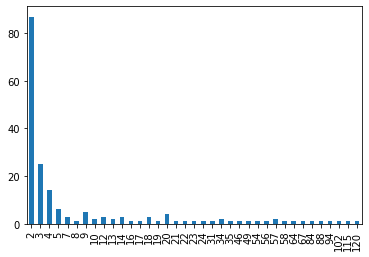

In [309]:
ax = pd.Series(jumps).value_counts().sort_index().plot.bar()

### Number of Slices By Patient

In [310]:
pd.Series(slice_counts).value_counts().sort_index()

1       5
2       2
3       4
4       1
8      32
9     211
10    285
11    378
12     99
13     61
14     30
15     14
16      7
17      3
18      4
19      1
21      1
22      1
25      1
dtype: int64

### Filter Outliers

In [311]:
prime_patients = copy.deepcopy(patients)
for outlier_patients in outliers.values():
    for p in outlier_patients:
        if p in prime_patients:
            del prime_patients[p]

In [313]:
prime_patients[2][1]

defaultdict(list,
            {10: 'kaggle/train/train/2/study/sax_10/IM-9578-0001.dcm',
             11: 'kaggle/train/train/2/study/sax_11/IM-9579-0001.dcm',
             12: 'kaggle/train/train/2/study/sax_12/IM-9580-0001.dcm',
             13: 'kaggle/train/train/2/study/sax_13/IM-9581-0001.dcm',
             14: 'kaggle/train/train/2/study/sax_14/IM-9582-0001.dcm',
             15: 'kaggle/train/train/2/study/sax_15/IM-9583-0001.dcm',
             5: 'kaggle/train/train/2/study/sax_5/IM-9573-0001.dcm',
             6: 'kaggle/train/train/2/study/sax_6/IM-9574-0001.dcm',
             7: 'kaggle/train/train/2/study/sax_7/IM-9575-0001.dcm',
             8: 'kaggle/train/train/2/study/sax_8/IM-9576-0001.dcm',
             9: 'kaggle/train/train/2/study/sax_9/IM-9577-0001.dcm'})

In [318]:
parent = 'KAG'
os.makedirs(parent, exist_ok=True)

for patient, phases in tqdm.tqdm(prime_patients.items()):
    for phase, slices in phases.items():
        for sid, path in slices.items():
            dcm = pydicom.dcmread(path)
            image = scale_pixel_array(dcm.pixel_array)
            dest = 'KAG/KAG_PA{:06d}_PH{:02d}_S{:02d}.png'.format(int(patient), int(phase), int(sid))
            cv2.imwrite(dest, image)
        break  # only one phase

100%|██████████| 974/974 [01:10<00:00, 13.75it/s]
